This notebook features the training of machine learning algorithms to learn about properties of barred and normal galaxies, data taken from the Carnegie Irvine Galaxy Survey.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

First, we import and rescale the images to 128 x 128 to speed up the training process.

In [40]:
image_width, image_height = 512, 512

def load_images(directory, label):
    images = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith('.jpg'):
            img = load_img(os.path.join(directory, file), target_size=(image_width, image_height))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(label)
    return images, labels

barred_spirals, y_barred = load_images('Barred_Spirals', 0)
normal_spirals, y_normal = load_images('Normal_Spirals', 1)

X = np.array(barred_spirals + normal_spirals)
y = np.array(y_barred + y_normal)

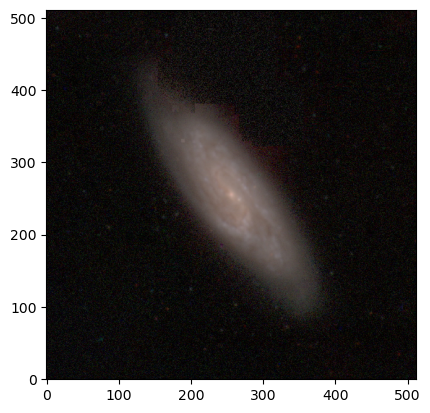

In [46]:
plt.imshow(barred_spirals[0],origin='lower')

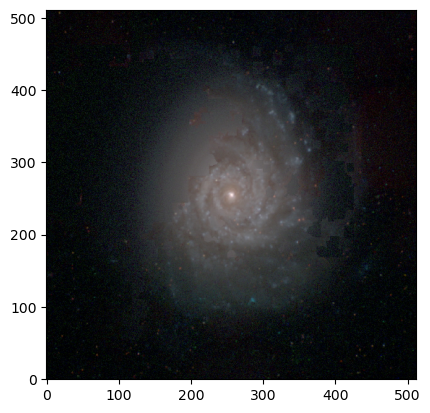

In [49]:
plt.imshow(normal_spirals[9],origin='lower')

Now, we split the data into training and testing sets.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We apply data augmentation. We run a test where we do not apply any data augmentation

In [36]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(X_train)


Now, we build the neural network.

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


Train the model.

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=8),
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100



KeyboardInterrupt



Evaluate the model's performance.

In [30]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred))

2/2 [==============================] - 0s 76ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61



/Users/kylekabasares/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kylekabasares/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kylekabasares/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Plot the learning curves associated with the learnig process.

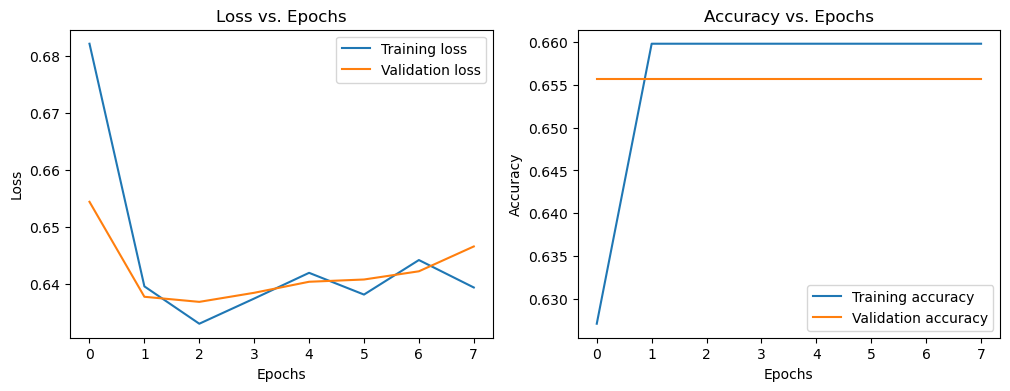

In [31]:
def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()

plot_learning_curves(history)


Now, I visualize the confusion matrix.

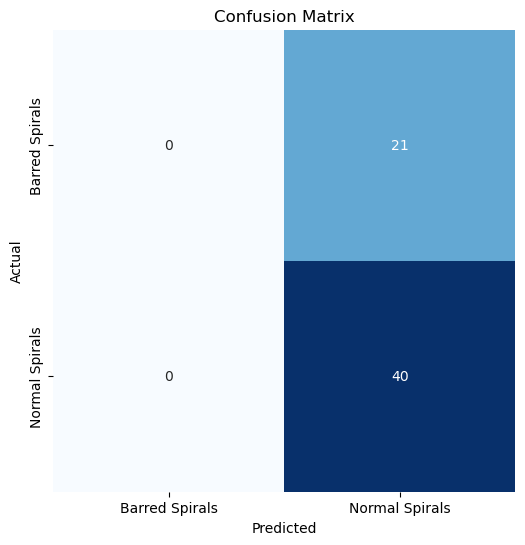

In [32]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=['Barred Spirals', 'Normal Spirals'],
                yticklabels=['Barred Spirals', 'Normal Spirals'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)


Plot the precision-recall curve.

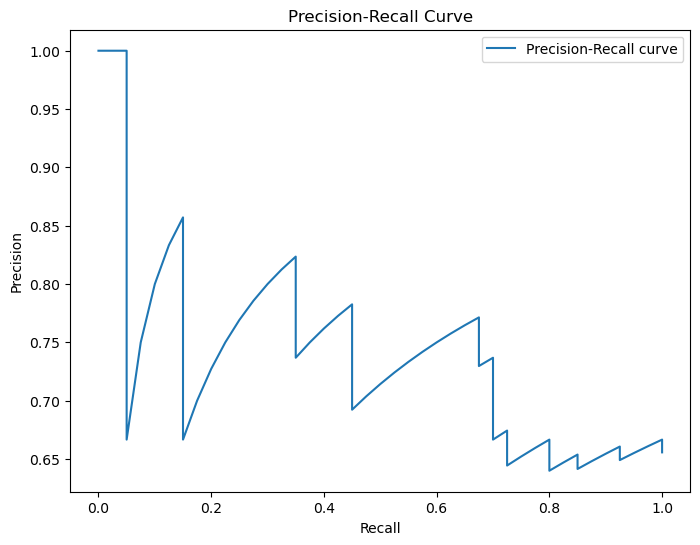

In [33]:
def plot_precision_recall_curve(y_test, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

plot_precision_recall_curve(y_test, y_pred_proba)
